# 线性回归 + 计算

## 基本概念

**一个简化模型**
1. 假设1：影响房价的关键因素是卧室个数，卫生间个数和居住面积，记为x1,x2,x3
2. 假设2: 成交价是关键因素的加权和
      y = w1*x1 + w2*x2 + w3*x3 + b

1. 线性回归是对n维输入的加权，外加偏差
2. 使用平方损失来衡量预测值和真实值的差异
3. 线性回归有显示解
4. 线性回归可以看作单层神经网络

**梯度下降**
1. 梯度下降通过不断沿着反梯度方向更新参数求解
2. 小批量随机梯度下降是深度学习默认的求解算法
3. 两个重要的超参数是批量大小和学习率

## 线性回归的实现

In [14]:
%matplotlib inline   
#jupyter中的内置命令，用于将绘图显示在页面内不是弹出框
import random
import torch
from d2l import torch as d2l

**根据有噪声的线性模型构造一个人造数据集。使用线性模型 $\pmb{w} = [2,-3.4]^T$、$b = 4.2$ 和噪声项 $\varepsilon$ 及其标签：**\
$\pmb{y}= \pmb{Xw} + b +  \varepsilon$

In [38]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    x = torch.normal(0,1, (num_examples, len(w)))   #生成x，是均值为 0， 方差为1的随机数，且向量x的元素个数为num_examples，列数为 w的长度
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)             #加入噪声，噪声的均值为0，方差为0.01，和y数量等同
    return x, y.reshape((-1,1))                     #将y作为一个列向量返回

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

 注释：
 方差计算公式   $\mu = \frac{1}{n} \sum_{i=1}^{n} x_i $

In [43]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.4620, -1.3070]) 
label: tensor([7.7308])


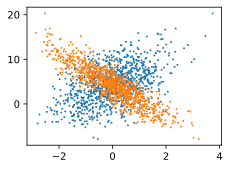

In [55]:
d2l.set_figsize()
d2l.plt.scatter(features[:,0].detach().numpy(),       #x1，x2，分别为x矩阵的两列
                labels.detach().numpy(), 1);          #作图，自变量为x1，因变量为y

d2l.plt.scatter(features[:,1].detach().numpy(),       #作图，自变量为x2，因变量为y
                labels.detach().numpy(), 1); 

**定义一个data_iter函数，接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量**

In [65]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)                        #把list中元素打乱，这样样本就是随机读取的
    for i in range(0, num_examples, batch_size):  # batch_size作为步长
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])    
        '''获取每个批次的索引，在下一行获取每个批次的数据，用i:min(i + batch_size, num_examples) 而不用 i:i+batch_size,
           是防止最后一批次溢出，如10个数据，每批次取3个，最后一批次只能取1，而不是3'''
        yield features[batch_indices], labels[batch_indices]  #获取每批次的数据

batch_size = 10
for X, y in data_iter(batch_size, features,labels):
    print(X,'\n', y)
    break              #获取第一批数据就跳出

tensor([[ 0.1184, -0.1673],
        [-2.8010,  0.8826],
        [-0.8410, -0.7825],
        [-0.9219, -0.3987],
        [ 0.2558,  1.2112],
        [-0.7662,  0.5339],
        [-0.2033, -0.7000],
        [-2.0240, -0.0693],
        [-1.4885, -0.0038],
        [-0.7105,  0.0390]]) 
 tensor([[ 5.0153],
        [-4.3771],
        [ 5.1661],
        [ 3.7143],
        [ 0.6084],
        [ 0.8514],
        [ 6.1644],
        [ 0.3916],
        [ 1.2366],
        [ 2.6407]])


**定义初始化模型参数**

In [72]:
w = torch.normal(0, 0.01, size=(2, 1) ,requires_grad=True)#生成一个形状为 (2, 1) 的张量，其中的元素是从均值为 0、标准差为 0.01 的正态分布中随机抽取的
b = torch.zeros(1,requires_grad = True)
'''
这里显示的标记了w和b需要计算梯度，这在下面的训练流程中PyTorch 通过自动求导机制（Autograd）自动构建计算图并计算梯度，那么 l.sum() ，loss的批量损失之和求导
就会记录w和b的梯度
'''

**定义模型**

In [75]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b     #线性回归模型

**定义损失函数**

In [78]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2   #均方损失

**定义优化算法**

In [85]:
"""小批量随机梯度下降"""
def sgd(params, lr, batch_size):   #参数、学习率、 小批量数量
    with torch.no_grad():          #更新不参与梯度计算
        for param in params:
            param -=lr * param.grad / batch_size
            param.grad.zero_()    #手动梯度置0

**训练过程**

**训练的目的是寻求合适的 w 和 b，来能够拟合我们的数据，获取较好的结果**
1. 第一步是随机初始化w 和 b
2. 第二步是定义函数模型为线性模型
3. 第三步是定义损失函数，及将w，b带入模型，使用样本点去相见获取损失值
4. 第四步是使用梯度下降逐步更新 w, b

In [88]:
lr = 0.03        #学习率围0.03
num_epochs = 3   #数据过三遍
net = linreg     #模型为线性模型
loss = squared_loss  #损失函数为均方损失

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):    
        l = loss(net(X, w, b), y)     #计算X 和 y 的小批量损失
        l.sum().backward()
        ''' 这里，l.sum() 将小批量损失求和，得到一个标量，然后调用 backward() 计算这个标量损失相对于模型参数 w 和 b 的梯度。
        这些梯度会被存储在 w.grad 和 b.grad 中,sgd进行批量更新需要这些梯度'''
        sgd([w,b], lr, batch_size)   #使用参数的梯度更新
    with torch.no_grad():            #with后是每次批量处理完后查看效果的，将全集带入loss查看，此时不需要计算梯度
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.026171
epoch 2, loss 0.000097
epoch 3, loss 0.000050


In [91]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-2.4033e-04, -7.1526e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)
